## Natural Languange Process (NLP) in Finance

This notebook provides an example of NLP in finance.

#### NLP Packages

* nltk - an NLP toolkit for Python (see https://www.nltk.org)

* en_core_web_sm - a pipeline tool for NLP with Python (see https://spacy.io/models/en)


In [1]:
import pandas as pd
import numpy as np
import itertools
import re

# NLP Toolkits
import nltk
import en_core_web_sm

from sklearn.feature_extraction.text import CountVectorizer

# Gaphics packages
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [8]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

nlp = en_core_web_sm.load()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


#### Text Data

We'll upload:
* **The Financial Phrase Bank** (Malo et al., 2014): This dataset comprises business phrases that have been annotated with sentiment scores. You can download this dataset from the Hugging Face datasets repository:


> https://huggingface.co/datasets/financial_phrasebank/tree/main/data



*  **The Loughran-McDonald Dictionary**: This dictionary is the benchmark for anyone working with financial and accounting texts. It maps words to specific sentiment categories, providing a nuanced tool for textual analysis in economics and finance. Detailed information and download options are available at the official website:



> https://sraf.nd.edu/loughranmcdonald-master-dictionary/



In [5]:
df_phrases = pd.read_csv('Sentences_AllAgree.txt', delimiter='@', encoding='latin-1', on_bad_lines='skip', names=['Phrase', 'Sentiment'])
df_phrases.head()

,Phrase,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


In [14]:
df_dictionary = pd.read_csv('Loughran-McDonald_MasterDictionary_1993-2024.csv', delimiter=',', on_bad_lines='skip', header=0)
df_dictionary.head()

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Complexity,Syllables,Source
0,AARDVARK,1,755,2.955070e-08,1.945421e-08,4.078069e-06,140,0,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.174200e-10,8.060019e-12,8.919011e-09,1,0,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,3.522600e-10,1.089343e-10,5.105359e-08,7,0,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,29,1.135060e-09,6.197922e-10,1.539279e-07,28,0,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,9620,3.765268e-07,3.825261e-07,3.421836e-05,1295,0,0,0,0,0,0,0,0,3,12of12inf


### Text as Data

#### Preprocessing text data

The following Python function, preprocess_text, performs several preprocessing steps on a given text to prepare it for natural language processing (NLP) tasks. These include:
* Converting all characters in the text to lowercase, to make the text case-insensitive
* Removing punctuation and non-alphanumeric characters: Uses a regular expression to remove any characters that are not alphanumeric (including punctuation), which helps in cleaning the text.
* Filtering out the stopwords, i.e., common words like "is", "and", "the", etc., that are often removed in NLP tasks because they carry less meaningful information.
* Lemmatization -- the process of reducing words to their base or dictionary form. For example, "running" becomes "run".

In [6]:
def preprocess_text(text, stopwrds):
  filtered_tokens = []

  # Convert text to lowercase
  text = text.lower()

  # Remove punctuation and non-alphanumeric characters using regular expression
  text = re.sub(r'\W+', ' ', text)

  # Tokenize text using NLTK
  word_tokens = word_tokenize(text)

  # Remove stop words
  if stopwrds:
    filtered_tokens = [word for word in word_tokens if word not in stop_words]

    # Reconstruct the text without stop words
    text = ' '.join(filtered_tokens)

  # Use spaCy for lemmatization
  doc = nlp(text)
  lemmatized_text = " ".join([token.lemma_ for token in doc])

  return lemmatized_text

In [9]:
df_phrases['Pre_Processed'] = df_phrases['Phrase'].apply(lambda x: preprocess_text(x, True))
df_phrases['Pre_Processed_w_stopwords'] = df_phrases['Phrase'].apply(lambda x: preprocess_text(x, False))
df_phrases.head()

,Phrase,Sentiment,Pre_Processed,Pre_Processed_w_stopwords
0,"According to Gran , the company has no plans t...",neutral,accord gran company plan move production russi...,accord to gran the company have no plan to mov...
1,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter 2010 componenta net sale double e...,for the last quarter of 2010 componenta s net ...
2,"In the third quarter of 2010 , net sales incre...",positive,third quarter 2010 net sale increase 5 2 eur 2...,in the third quarter of 2010 net sale increase...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,operating profit rise eur 13 1 mn eur 8 7 mn c...,operating profit rise to eur 13 1 mn from eur ...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,operating profit total eur 21 1 mn eur 18 6 mn...,operating profit total eur 21 1 mn up from eur...


#### Bag of Words (document-term matrix)

The following code blocks performs a Bag of Words (BoW) transformation on the pre-processed phrases and then visualizes the most common words found in those phrases.
*   CountVectorizer - a method for converting text data into a matrix of token counts. Each row corresponds to a document (in this case, a processed phrase) and each column represents a unique word across all documents, i.e., a document-term matrix.
*   word_sum - sums the occurrences for each word across all phrases, and then this sum is then sorted in descending order to identify the most common words.

In [10]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_phrases['Pre_Processed'])
df_bow = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

word_sum = df_bow.sum(axis=0).sort_values(ascending=False)

print(df_bow.iloc[2000:2031, 1270:1275])

      community  companiesandmarket  company  comparable  comparative
2000          0                   0        0           0            0
2001          0                   0        1           0            0
2002          0                   0        0           0            0
2003          0                   0        0           0            0
2004          0                   0        0           0            0
2005          0                   0        0           0            0
2006          0                   0        0           0            0
2007          0                   0        0           0            0
2008          0                   0        0           0            0
2009          0                   0        0           0            0
2010          0                   0        1           0            0
2011          0                   0        0           0            0
2012          0                   0        1           0            0
2013          0     

<ipython-input-12-987b79d30fa4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_sum[:25].values, y=word_sum[0:25].index, palette='viridis')


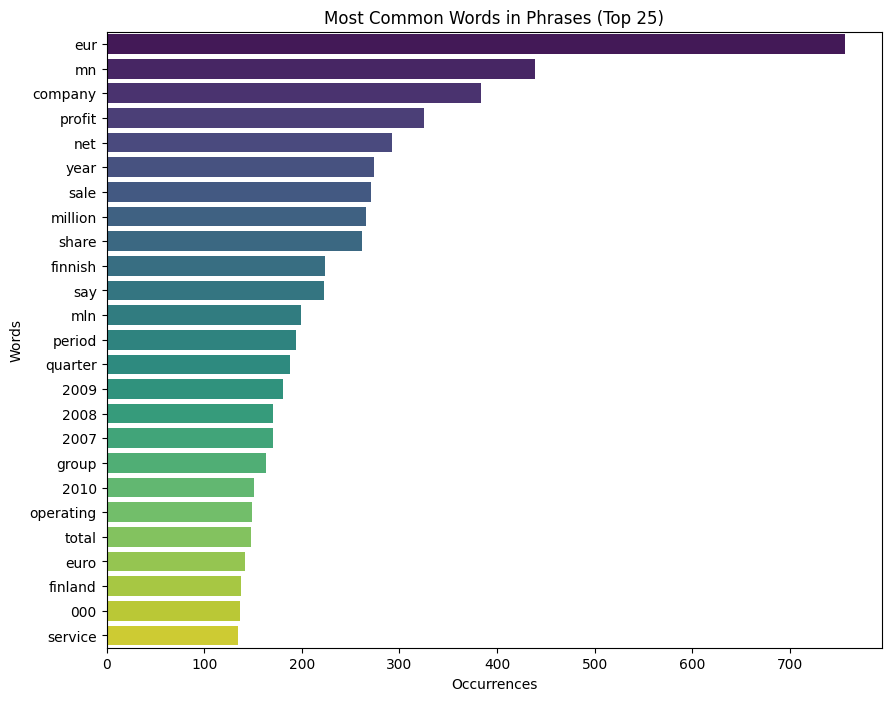

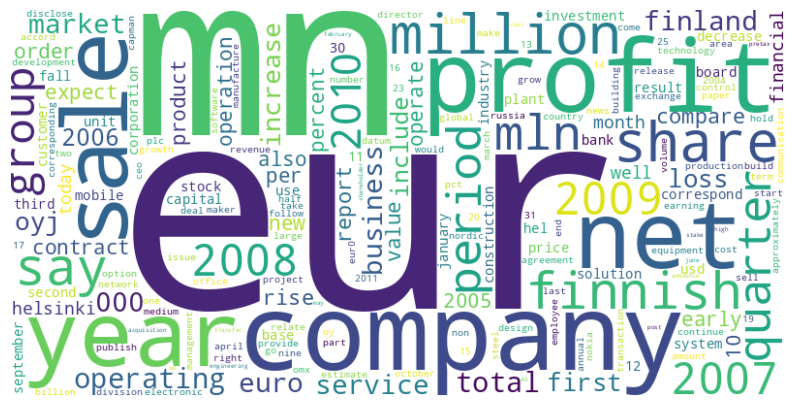

In [12]:
# Visualization - Barplot

plt.figure(figsize=(10, 8))
sns.barplot(x=word_sum[:25].values, y=word_sum[0:25].index, palette='viridis')
plt.title('Most Common Words in Phrases (Top 25)')
plt.xlabel('Occurrences')
plt.ylabel('Words')
plt.show()

print('\n')

# Visualization - Word cloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_sum)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Sentiment Analysis

Compare the human-annotated sentiment identfied in the Financial Phrase Bank to the sentiment identified by the Loughran-McDonald Dictionary.

Create lists for the positive words, positive_words, and negative words, negative_words, identified in the dictionary (making the words lower case and lemmatizing).

In [16]:
negative_words = list(df_dictionary[df_dictionary['Negative'] > 0]['Word'].str.lower())
positive_words = list(df_dictionary[df_dictionary['Positive'] > 0]['Word'].str.lower())

positive_words[0:10]

['able',
 'abundance',
 'abundant',
 'acclaimed',
 'accomplish',
 'accomplished',
 'accomplishes',
 'accomplishing',
 'accomplishment',
 'accomplishments']

In [17]:
def lemma_words(word_lst):

  lemma_word_lst = []

  # Process each word with spaCy to obtain its lemma
  for word in word_lst:
    # Process the word to create a document object
    doc = nlp(word)
    # Since each 'word' is actually just one word, we can take the lemma of the first token
    lemmatized_word = doc[0].lemma_
    # Append the lemmatized word to the list
    lemma_word_lst.append(lemmatized_word)

  return list(set(lemma_word_lst))


positive_words = lemma_words(positive_words)
negative_words = lemma_words(negative_words)

for word in negative_words[:10]:
  print(word)

frivolous
untruthfulness
accusation
nullification
calamity
unwarranted
disastrous
revoke
unemployed
vandalism


For each phrase in the Financial Phrase Bank, we can determine the sentiment identified by the Loughran-McDonald Dictionary as the difference between the number of positive words and the number of negative words in each Phrase.

In [18]:
def sentiment_difference(phrase):
  tokens = phrase.split()

  positive_count = sum(token in positive_words for token in tokens)
  negative_count = sum(token in negative_words for token in tokens)

  return positive_count - negative_count

df_phrases['LM_Sentiment'] = df_phrases['Pre_Processed_w_stopwords'].apply(sentiment_difference)

df_phrases

,Phrase,Sentiment,Pre_Processed,Pre_Processed_w_stopwords,LM_Sentiment
0,"According to Gran , the company has no plans t...",neutral,accord gran company plan move production russi...,accord to gran the company have no plan to mov...,0
1,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter 2010 componenta net sale double e...,for the last quarter of 2010 componenta s net ...,-1
2,"In the third quarter of 2010 , net sales incre...",positive,third quarter 2010 net sale increase 5 2 eur 2...,in the third quarter of 2010 net sale increase...,0
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,operating profit rise eur 13 1 mn eur 8 7 mn c...,operating profit rise to eur 13 1 mn from eur ...,0
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,operating profit total eur 21 1 mn eur 18 6 mn...,operating profit total eur 21 1 mn up from eur...,0
...,...,...,...,...,...
2259,Operating result for the 12-month period decre...,negative,operating result 12 month period decrease prof...,operating result for the 12 month period decre...,0
2260,HELSINKI Thomson Financial - Shares in Cargote...,negative,helsinki thomson financial share cargotec fall...,helsinki thomson financial share in cargotec f...,-3
2261,LONDON MarketWatch -- Share prices ended lower...,negative,london marketwatch share price end low london ...,london marketwatch share price end lower in lo...,-1
2262,Operating profit fell to EUR 35.4 mn from EUR ...,negative,operating profit fall eur 35 4 mn eur 68 8 mn ...,operating profit fall to eur 35 4 mn from eur ...,1


#### What empirical results are there regarding sentiment predicting returns?

* Tetlock, P. C. (2007). Giving content to investor sentiment: The role of media in the stock market. The Journal of Finance, 62(3), 1139–1168.

> https://www.jstor.org/stable/4622297
> https://papers.ssrn.com/sol3/papers.cfm?abstract_id=685145


* Garcia, D. (2013). Sentiment during recessions. The Journal of Finance, 68(3), pp. 1267-1300


> https://www.jstor.org/stable/42002620
> https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1571101


* Birru, J., & Young, T. (2022). Sentiment and uncertainty. Journal of Financial Economics, 146(3), 1148–1169.

> https://www.sciencedirect.com/science/article/abs/pii/S0304405X2200112X



#### What about media other than newspapers?

* Das, S. R., & Chen, M. Y. (2007). Yahoo! for Amazon: Sentiment Extraction from Small Talk on the Web. Management Science, 53(9), 1375–1388.

> https://www.jstor.org/stable/20122297

* Hailiang Chen, Prabuddha De, Yu Jeffrey Hu, & Byoung-Hyoun Hwang. (2014). Wisdom of crowds: the value of stock opinions transmitted through social media. The Review of Financial Studies.


> https://doi.org/10.1093/rfs/hhu001


### ML-Based Sentiment Analysis

Machine learning-based sentiment analysis, particularly large language models, use word and sentence vector embeddings to capture nuanced linguistic features and context. This contextual awareness should, in theory, see them significantly outperform dictionary-based methods.

The [CLS] token in BERT, representing the entire input sequence, enables the model to understand complex sentiment indicators such as negation and sarcasm.

The following code generates [CLS] tokens for two sentences using BERT, and identifies the difference in the representations.

In [19]:
from transformers import BertTokenizer, BertModel
import torch

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Two sentences for comparison
sentence1 = "Here is an example of a positive sentence for generating embeddings."
sentence2 = "Here is an example of a negative sentence for generating embeddings."

# Tokenize and encode sentences for BERT input
inputs1 = tokenizer(sentence1, return_tensors="pt")
inputs2 = tokenizer(sentence2, return_tensors="pt")

# Generate embeddings for both sentences
with torch.no_grad():
    outputs1 = model(**inputs1)
    outputs2 = model(**inputs2)

# Extract [CLS] token embeddings for both sentences
cls_embedding1 = outputs1.last_hidden_state[:, 0, :]
cls_embedding2 = outputs2.last_hidden_state[:, 0, :]

# Compute the difference in embeddings between the two sentences
embedding_difference = cls_embedding1 - cls_embedding2

# Show the shape of the embeddings and the difference
cls_embedding1.shape, cls_embedding2.shape, embedding_difference



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

(torch.Size([1, 768]),
 torch.Size([1, 768]),
 tensor([[ 0.0339, -0.0128,  0.0827,  0.0113, -0.0154, -0.0551, -0.0583, -0.0029,
          -0.0059, -0.0129, -0.0588, -0.0233, -0.0246,  0.0094, -0.0082, -0.0427,
          -0.0314,  0.0312, -0.0217, -0.0059,  0.0016, -0.0187,  0.0100, -0.0004,
          -0.0241,  0.0603, -0.0063, -0.0129, -0.0080,  0.0381,  0.0014,  0.0061,
           0.0436, -0.0034, -0.0009,  0.0004,  0.0757,  0.0051,  0.0103, -0.0392,
          -0.0037, -0.0061,  0.0598,  0.0002, -0.0230,  0.0099, -0.0601,  0.0506,
           0.0146,  0.0204,  0.0576, -0.0139, -0.0153, -0.0149,  0.0360,  0.0079,
           0.0649,  0.0234, -0.0161, -0.0203, -0.0089,  0.0203, -0.0085, -0.0256,
           0.0622, -0.0183,  0.0432, -0.0555,  0.0762,  0.0048,  0.0329,  0.0015,
           0.0044,  0.0005, -0.0318, -0.0100, -0.0432, -0.0902,  0.0042, -0.0263,
          -0.0197, -0.0197,  0.0178, -0.0200, -0.0364,  0.0568,  0.0231, -0.0053,
          -0.0105,  0.0493,  0.0059, -0.0094,  0.022